# 3. Data Pre-Processing
In this notebook, we will focus on several key data pre-processing steps to ensure the dataset is ready for model training and evaluation. These steps address the following issues:

1. Data Splitting: We will begin by splitting the dataset into training and testing sets. This step is done before other pre-processing steps to helps prevent data leakage.
2. Categorical Variable Encoding: Machine learning models typically require numerical input, so we will apply encoding techniques to transform categorical variables into a numerical format that the models can understand.
3. Numerical Variable Scaling: Scaling numerical variables can enhance model performance and convergence. We will explore various scaling methods and select the most suitable one for our dataset.
4. Addressing Class Imbalance: Our dataset exhibits a slight imbalance between classes. To address this issue and improve the representativeness of the minority class, we will employ resampling methods.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# For resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC

## Import Cleaned Dataset

In [2]:
df = pd.read_csv('Data/cleaned.csv')

In [3]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,inn00001,2,0,1,2,meal plan 1,0,room_type 1,224,2017,10,2,offline,0,0,0,65.00,0,not_canceled
1,inn00002,2,0,2,3,not selected,0,room_type 1,5,2018,11,6,online,0,0,0,106.68,1,not_canceled
2,inn00003,1,0,2,1,meal plan 1,0,room_type 1,1,2018,2,28,online,0,0,0,60.00,0,canceled
3,inn00004,2,0,0,2,meal plan 1,0,room_type 1,211,2018,5,20,online,0,0,0,100.00,0,canceled
4,inn00005,2,0,1,1,not selected,0,room_type 1,48,2018,4,11,online,0,0,0,94.50,0,canceled


In [4]:
df.columns

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')

## Train-Test Split

There are two possible methods for train-test split:

1. **Random Split (80/20 Rule)**: This method involves randomly dividing the dataset into training and test sets, typically with a split ratio of 80% for training and 20% for testing.
2. **Date-Based Split**: This method splits the data based on the booking date, where entries from earlier dates are assigned to the training set and those from later dates are assigned to the test set. 

We will adopt method 2 because it closely mimics real-life scenarios, where predictions are made using historical data to forecast future outcomes. Additionally, the size of the training and test sets will be approximately 80:20, ensuring a balanced distribution.

In [5]:
# create booking_date
temp = df.rename(columns={
    'arrival_year': 'year',
    'arrival_month': 'month',
    'arrival_date': 'day'
})

df['booking_date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
df['booking_date'] = df['booking_date'] - pd.Series(
    [pd.Timedelta(i, 'd') for i in df.lead_time],
    index=df.index
)

In [6]:
max(df['booking_date'])

Timestamp('2018-12-30 00:00:00')

In [7]:
# split based on booking_date
train = df[df['booking_date']<'2018-07-01'].reset_index(drop=True)
test = df[df['booking_date']>='2018-07-01'].reset_index(drop=True)

In [8]:
print(f'Size of training set: {len(train)}')
print(f'Size of test set: {len(test)}')

Size of training set: 28062
Size of test set: 8176


## Preprocessing on Categorical Variables

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36238 entries, 0 to 36237
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Booking_ID                            36238 non-null  object        
 1   no_of_adults                          36238 non-null  int64         
 2   no_of_children                        36238 non-null  int64         
 3   no_of_weekend_nights                  36238 non-null  int64         
 4   no_of_week_nights                     36238 non-null  int64         
 5   type_of_meal_plan                     36238 non-null  object        
 6   required_car_parking_space            36238 non-null  int64         
 7   room_type_reserved                    36238 non-null  object        
 8   lead_time                             36238 non-null  int64         
 9   arrival_year                          36238 non-null  int64         
 10

From the above info, we can see that in the dataset, we have many categorical attributes. In order to perform classification, additional data preprocessing has to be done. Let's take a look at the attributes that are non-numerical (Categorical)

In [10]:
df.select_dtypes(exclude=['int64', 'float64', 'int32', 'float32']).head()

,Booking_ID,type_of_meal_plan,room_type_reserved,market_segment_type,booking_status,booking_date
0,inn00001,meal plan 1,room_type 1,offline,not_canceled,2017-02-20
1,inn00002,not selected,room_type 1,online,not_canceled,2018-11-01
2,inn00003,meal plan 1,room_type 1,online,canceled,2018-02-27
3,inn00004,meal plan 1,room_type 1,online,canceled,2017-10-21
4,inn00005,not selected,room_type 1,online,canceled,2018-02-22


Let's also explore what are the possible values given the different categorical attributes. From this, we can identify nominal and ordinal categories, this is important since we would use different preprocessing method depending on the category type.

For example, for <b>ordinal data</b> (e.g. Low, med high), there is a natural order to the data, and hence we could replace the values using ordinal encoding, where we map each category with numbers to represent that order.

For <b>nominal data</b> (e.g. Red Blue Green), there is no natural order, we cannot simply apply the same strategy as above, since that would imply an artificial order for the data, which is not true. In this case, a strategy we could use is one-hot encoding.

In [11]:
print("Booking_ID unique values: ", df['Booking_ID'].unique(), "\n")
print("type_of_meal_plan unique values: ", df['type_of_meal_plan'].unique(), "\n")
print("room_type_reserved unique values: ", df['room_type_reserved'].unique(), "\n")
print("market_segment_type unique values: ", df['market_segment_type'].unique(), "\n")
print("booking_status unique values: ", df['booking_status'].unique(), "\n")

Booking_ID unique values:  ['inn00001' 'inn00002' 'inn00003' ... 'inn36273' 'inn36274' 'inn36275'] 

type_of_meal_plan unique values:  ['meal plan 1' 'not selected' 'meal plan 2' 'meal plan 3'] 

room_type_reserved unique values:  ['room_type 1' 'room_type 4' 'room_type 2' 'room_type 6' 'room_type 5'
 'room_type 7' 'room_type 3'] 

market_segment_type unique values:  ['offline' 'online' 'corporate' 'aviation' 'complementary'] 

booking_status unique values:  ['not_canceled' 'canceled'] 



### Based on results, we can see a few observations:
1. Each Booking_ID is unique for each row, this attribute is only used as an identifier to a row, this also means that these are arbitrary values that do not contain any information that helps the model learn patterns related to the target variable, hence we can actually exclude this attribute during our model training.
2. All of the categories appears to be of nominal data type, where there is no real natural order, hence a good strategy we can use here would be one-hot encoding. One-hot encoding creates a binary column for each category and gives a 1 or 0 value to indicate true or false.
3. For Booking_Status, this is actually our target attribute, it only has two possible values (canceled and not_canceled), in this case, we can just use a label encoding to transform the values into a binary value (1 and 0).

In [12]:
# Drop the Booking_ID column as this will not be helpful in training the classification model.
train = train.drop('Booking_ID', axis = 1)
test = test.drop('Booking_ID', axis = 1)

In [13]:
# Encode booking_status
train['booking_status'] = train['booking_status'].apply(lambda x: 1 if x=='canceled' else 0)
test['booking_status'] = test['booking_status'].apply(lambda x: 1 if x=='canceled' else 0)

Hence we have the remaining categorical columns to preprocess:

In [14]:
# Categoriy columns that needs to be preprocessed for classification
cat_cols_to_be_encoded = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'arrival_month']

# Category columns that are already in the binary format (distinct 0 and 1 values)
cat_cols_already_in_the_right_format = ['required_car_parking_space', 'repeated_guest']


There are several ways for encoding categorical varaibles:
1. <b>OrdinalEncoder</b>: Preserves the ordinal relationship between categories, useful when the categorical variables have an inherent order
2. <b>OneHotEncoder</b>: Creates binary columns for each category, indicating the presence or absence of each category, suitable for nominal data with no ordinal relationship
3. <b>TargetEncoder</b>: Replaces categories with the mean of the target variable for each category, useful for high-cardinality categorical variables
4. <b>FrequencyEncoding</b>: Encodes categorical variables based on the frequency of each category in the dataset, useful when the frequency of occurrence is informative, but can lead to information loss

For the above variables, they have small cardinalities and are nominal data, so OneHotEncoding is the most suitable method.

In [15]:
# fit on training data
enc = OneHotEncoder(handle_unknown='error')
enc.fit(train[cat_cols_to_be_encoded])
train[enc.get_feature_names_out()] = enc.transform(train[cat_cols_to_be_encoded]).toarray()

In [16]:
# transform test data
test[enc.get_feature_names_out()] = enc.transform(test[cat_cols_to_be_encoded]).toarray()

In [17]:
# store the categorical column names after encoding
encoded_cat_cols = enc.get_feature_names_out()

# append the encoded_cat_cols with the columns that are already in the right format
encoded_cat_cols = np.append(encoded_cat_cols, cat_cols_already_in_the_right_format)
encoded_cat_cols

array(['type_of_meal_plan_meal plan 1', 'type_of_meal_plan_meal plan 2',
       'type_of_meal_plan_meal plan 3', 'type_of_meal_plan_not selected',
       'room_type_reserved_room_type 1', 'room_type_reserved_room_type 2',
       'room_type_reserved_room_type 3', 'room_type_reserved_room_type 4',
       'room_type_reserved_room_type 5', 'room_type_reserved_room_type 6',
       'room_type_reserved_room_type 7', 'market_segment_type_aviation',
       'market_segment_type_complementary',
       'market_segment_type_corporate', 'market_segment_type_offline',
       'market_segment_type_online', 'arrival_month_1', 'arrival_month_2',
       'arrival_month_3', 'arrival_month_4', 'arrival_month_5',
       'arrival_month_6', 'arrival_month_7', 'arrival_month_8',
       'arrival_month_9', 'arrival_month_10', 'arrival_month_11',
       'arrival_month_12', 'required_car_parking_space', 'repeated_guest'],
      dtype=object)

For now, all categories are kept to ensure interpretability. To avoid multicollinearity issues in linear models, extra steps can be done to remove some of the attributes.

In [18]:
# Quick Peek at the dataset after categorical preprocessing to verify one hot encoding is successful.
train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,...,arrival_month_3,arrival_month_4,arrival_month_5,arrival_month_6,arrival_month_7,arrival_month_8,arrival_month_9,arrival_month_10,arrival_month_11,arrival_month_12
0,2,0,1,2,meal plan 1,0,room_type 1,224,2017,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,0,2,1,meal plan 1,0,room_type 1,1,2018,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,0,2,meal plan 1,0,room_type 1,211,2018,5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0,1,1,not selected,0,room_type 1,48,2018,4,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,0,0,2,meal plan 2,0,room_type 1,346,2018,9,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Feature Engineering on Numerical Variables

For machine learning algorithm that requires gradient descent or distance measurement, feature scaling is necessary. There are several ways of scaling:
1. **Min-Max Scaling**: Scales the data to a fixed range, usually between 0 and 1, useful when the distribution of data is uniform or when the algorithm requires input features to be on a similar scale
2. **Standardization**: Scales the data to have a mean of 0 and a standard deviation of 1, preserves the shape of the original distribution and is less affected by outliers

We will experiment with both methods and compare the performance in the following sections.

In [19]:
num_cols = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'no_of_previous_cancellations', 
            'no_of_previous_bookings_not_canceled', 'no_of_special_requests', 'lead_time', 'avg_price_per_room']

### Minmax Scaling

In [20]:
# fit on training data
minmax = MinMaxScaler()
minmax.fit(train[num_cols])
train[[x+'_minmax' for x in num_cols]] = minmax.transform(train[num_cols])

In [21]:
# transform test data
test[[x+'_minmax' for x in num_cols]] = minmax.transform(test[num_cols])

In [22]:
# store the numerical column names after scaling
minmax_num_cols = [x+'_minmax' for x in num_cols]
minmax_num_cols

['no_of_adults_minmax',
 'no_of_children_minmax',
 'no_of_weekend_nights_minmax',
 'no_of_week_nights_minmax',
 'no_of_previous_cancellations_minmax',
 'no_of_previous_bookings_not_canceled_minmax',
 'no_of_special_requests_minmax',
 'lead_time_minmax',
 'avg_price_per_room_minmax']

### Standardization

In [23]:
# fit on training data
scaler = StandardScaler()
scaler.fit(train[num_cols])
train[[x+'_scaled' for x in num_cols]] = scaler.transform(train[num_cols])

In [24]:
# transform test data
test[[x+'_scaled' for x in num_cols]] = scaler.transform(test[num_cols])

In [25]:
# store the numerical column names after scaling
scaled_num_cols = [x+'_scaled' for x in num_cols]
scaled_num_cols

['no_of_adults_scaled',
 'no_of_children_scaled',
 'no_of_weekend_nights_scaled',
 'no_of_week_nights_scaled',
 'no_of_previous_cancellations_scaled',
 'no_of_previous_bookings_not_canceled_scaled',
 'no_of_special_requests_scaled',
 'lead_time_scaled',
 'avg_price_per_room_scaled']

## Examination with Logistic Regression

Train and test set will first be prepared for model building. Then a logistic regression will be fitted to the 2 sets of processed data and compared the performance:
1. encoded categorical variables + minmax scaled numerical variables
2. encoded categorical variables + standardized numerical variables 

In [26]:
X_train = train.drop(['booking_status'], axis = 1)
Y_train = train['booking_status']
X_test = test.drop(['booking_status'], axis = 1)
Y_test = test['booking_status']

In [27]:
X_train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,...,avg_price_per_room_minmax,no_of_adults_scaled,no_of_children_scaled,no_of_weekend_nights_scaled,no_of_week_nights_scaled,no_of_previous_cancellations_scaled,no_of_previous_bookings_not_canceled_scaled,no_of_special_requests_scaled,lead_time_scaled,avg_price_per_room_scaled
0,2,0,1,2,meal plan 1,0,room_type 1,224,2017,10,...,0.120370,0.294807,-0.249422,0.216298,-0.179429,-0.060459,-0.090352,-0.736764,1.363410,-1.078369
1,1,0,2,1,meal plan 1,0,room_type 1,1,2018,2,...,0.111111,-1.645814,-0.249422,1.360457,-0.890405,-0.060459,-0.090352,-0.736764,-1.076089,-1.229683
2,2,0,0,2,meal plan 1,0,room_type 1,211,2018,5,...,0.185185,0.294807,-0.249422,-0.927860,-0.179429,-0.060459,-0.090352,-0.736764,1.221197,-0.019170
3,2,0,1,1,not selected,0,room_type 1,48,2018,4,...,0.175000,0.294807,-0.249422,0.216298,-0.890405,-0.060459,-0.090352,-0.736764,-0.561935,-0.185616
4,2,0,0,2,meal plan 2,0,room_type 1,346,2018,9,...,0.212963,0.294807,-0.249422,-0.927860,-0.179429,-0.060459,-0.090352,0.606122,2.698023,0.434772


### encoded categorical variables + scaled numerical variables

In [28]:
logRegModel = LogisticRegression(max_iter=10000).fit(X_train[list(encoded_cat_cols)+list(scaled_num_cols)], Y_train)

# Predict on the training and test data
Y_train_pred = logRegModel.predict(X_train[list(encoded_cat_cols)+list(scaled_num_cols)])
Y_test_pred = logRegModel.predict(X_test[list(encoded_cat_cols)+list(scaled_num_cols)])

In [29]:
# Calculate general metrics for the train set
print("**Training Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_train, Y_train_pred))
print("Precision \t:", precision_score(Y_train, Y_train_pred))
print("Recall \t\t:", recall_score(Y_train, Y_train_pred))
print("F1 Score \t:", f1_score(Y_train, Y_train_pred))

print() # New Line

# Calculate general metrics for the test set
print("**Test Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_test, Y_test_pred))
print("Precision \t:", precision_score(Y_test, Y_test_pred))
print("Recall \t\t:", recall_score(Y_test, Y_test_pred))
print("F1 Score \t:", f1_score(Y_test, Y_test_pred))

**Training Set Metrics**
Accuracy 	: 0.8022949183949826
Precision 	: 0.7495168563452866
Recall 		: 0.6846802667712829
F1 Score 	: 0.7156330087134802

**Test Set Metrics**
Accuracy 	: 0.815068493150685
Precision 	: 0.6009501187648456
Recall 		: 0.30083234244946494
F1 Score 	: 0.4009508716323296


### encoded categorical variables + minmax scaled numerical variables

In [30]:
logRegModel = LogisticRegression(max_iter=10000).fit(X_train[list(encoded_cat_cols)+list(minmax_num_cols)], Y_train)

# Predict on the training and test data
Y_train_pred = logRegModel.predict(X_train[list(encoded_cat_cols)+list(minmax_num_cols)])
Y_test_pred = logRegModel.predict(X_test[list(encoded_cat_cols)+list(minmax_num_cols)])

In [31]:
# Calculate general metrics for the train set
print("**Training Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_train, Y_train_pred))
print("Precision \t:", precision_score(Y_train, Y_train_pred))
print("Recall \t\t:", recall_score(Y_train, Y_train_pred))
print("F1 Score \t:", f1_score(Y_train, Y_train_pred))

print() # New Line

# Calculate general metrics for the test set
print("**Test Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_test, Y_test_pred))
print("Precision \t:", precision_score(Y_test, Y_test_pred))
print("Recall \t\t:", recall_score(Y_test, Y_test_pred))
print("F1 Score \t:", f1_score(Y_test, Y_test_pred))

**Training Set Metrics**
Accuracy 	: 0.8027581783194355
Precision 	: 0.7524645217202903
Recall 		: 0.681247548058062
F1 Score 	: 0.7150872497040202

**Test Set Metrics**
Accuracy 	: 0.8180039138943248
Precision 	: 0.6246786632390745
Recall 		: 0.28894173602853745
F1 Score 	: 0.39512195121951216


The results indicate that standardizing the numerical variables leads to slightly better performance. This improvement could be attributed to the robustness of standardization against extreme values present in our dataset, as well as its independence from the requirement for data to follow a specific distribution.

Having completed the preprocessing steps, the next task is to address the issue of data imbalance.

## Save Processed Datasets

In [32]:
original_cols = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests']

In [33]:
X_train[list(encoded_cat_cols)+list(scaled_num_cols)+original_cols].to_csv('Data/X_train.csv', index = False)
Y_train.to_csv('Data/y_train.csv', index = False)
X_test[list(encoded_cat_cols)+list(scaled_num_cols)+original_cols].to_csv('Data/X_test.csv', index = False)
Y_test.to_csv('Data/y_test.csv', index = False)

In [34]:
# store the column names used for model building
columns = pd.DataFrame({'Columns':list(encoded_cat_cols)+list(scaled_num_cols)})

In [92]:
columns.to_csv('Data/basic_model_columns.csv', index=False)

## Resampling

### Current Distribution

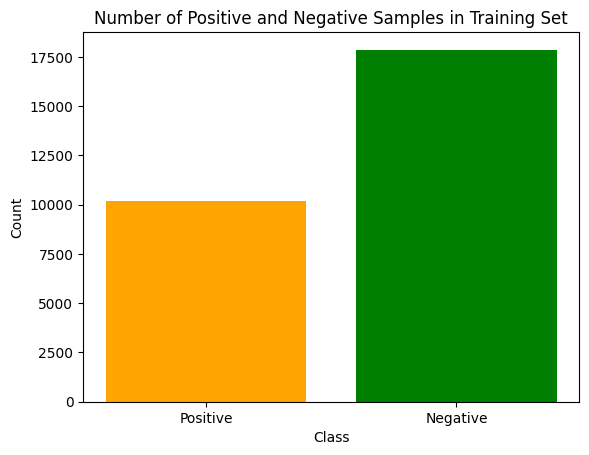

In [38]:
num_positive = sum(Y_train == 1)
num_negative = sum(Y_train == 0)

# Plotting
plt.bar(['Positive', 'Negative'], [num_positive, num_negative], color=['orange', 'green'])
plt.title('Number of Positive and Negative Samples in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Our dataset possesses a moderate level of **imbalance**, with the negative class outnumbering the positive class by a factor of **0.75**. This may lead to poor performance in predicting the minority class. Resampling techniques should be employed to ensure that predictive models effectively capture patterns from the positive class, as we are particularly interested in detecting positives in hotel booking cancellations.

In [39]:
# helper function for calculating evaluation scores
def evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred):
    train_metric = {
        "Accuracy": accuracy_score(Y_train, Y_train_pred),
        "Precision": precision_score(Y_train, Y_train_pred),
        "Recall": recall_score(Y_train, Y_train_pred),
        "F1 Score": f1_score(Y_train, Y_train_pred)
    }

    test_metric = {
        "Accuracy": accuracy_score(Y_test, Y_test_pred),
        "Precision": precision_score(Y_test, Y_test_pred),
        "Recall": recall_score(Y_test, Y_test_pred),
        "F1 Score": f1_score(Y_test, Y_test_pred)
    }

    # Calculate general metrics for the train set
    print("**Training Set Metrics**")
    print("Accuracy \t:", train_metric["Accuracy"])
    print("Precision \t:", train_metric["Precision"])
    print("Recall \t\t:", train_metric["Recall"])
    print("F1 Score \t:", train_metric["F1 Score"])

    print() # New Line

    # Calculate general metrics for the test set
    print("**Test Set Metrics**")
    print("Accuracy \t:", test_metric["Accuracy"])
    print("Precision \t:", test_metric["Precision"])
    print("Recall \t\t:", test_metric["Recall"])
    print("F1 Score \t:", test_metric["F1 Score"])

### Random Under-sampling

**Undersampling** is a method used to balance imbalanced datasets by retaining all instances from the minority class while reducing the number of instances from the majority class.

In [40]:
undersampler = RandomUnderSampler(random_state=42)

# Resample the training data
X_train_under_resampled, y_train_under_resampled = undersampler.fit_resample(X_train, Y_train)

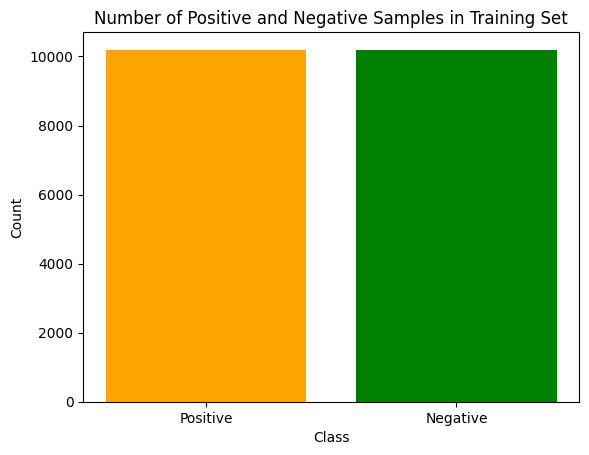

In [42]:
num_positive = sum(y_train_under_resampled == 1)
num_negative = sum(y_train_under_resampled == 0)

# Plotting
plt.bar(['Positive', 'Negative'], [num_positive, num_negative], color=['orange', 'green'])
plt.title('Number of Positive and Negative Samples in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [44]:
logRegModel = LogisticRegression(max_iter=10000).fit(X_train_under_resampled[columns['Columns']], y_train_under_resampled.values.ravel())

# Predict the output based on our training and testing dataset
y_train_pred = logRegModel.predict(X_train_under_resampled[columns['Columns']])
y_test_pred = logRegModel.predict(X_test[columns['Columns']])

In [45]:
evaluate(y_train_under_resampled, y_train_pred, Y_test, y_test_pred)

**Training Set Metrics**
Accuracy 	: 0.7880051000392311
Precision 	: 0.7854573733838826
Recall 		: 0.7924676343664182
F1 Score 	: 0.7889469316018162

**Test Set Metrics**
Accuracy 	: 0.8136007827788649
Precision 	: 0.5600303951367781
Recall 		: 0.43816884661117717
F1 Score 	: 0.4916611074049366


### Random Over-sampling

**Oversampling** is a technique employed to address class imbalance in datasets by increasing the number of instances in the minority class, typically through duplication or generation of synthetic data, to achieve a more balanced distribution of classes for improved model training.

In [46]:
# Instantiate RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Resample the training data
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, Y_train)

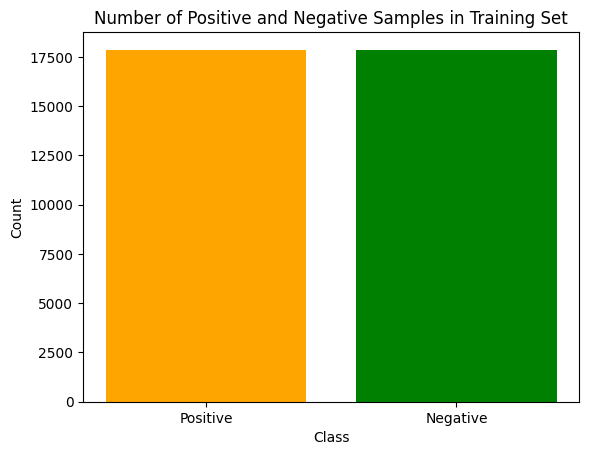

In [48]:
num_positive = sum(y_train_resampled == 1)
num_negative = sum(y_train_resampled == 0)

# Plotting
plt.bar(['Positive', 'Negative'], [num_positive, num_negative], color=['orange', 'green'])
plt.title('Number of Positive and Negative Samples in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [49]:
logRegModel = LogisticRegression(max_iter=10000).fit(X_train_resampled[columns['Columns']], y_train_resampled.values.ravel())

# Predict the output based on our training and testing dataset
y_train_pred = logRegModel.predict(X_train_resampled[columns['Columns']])
y_test_pred = logRegModel.predict(X_test[columns['Columns']])

In [50]:
evaluate(y_train_resampled, y_train_pred, Y_test, y_test_pred)

**Training Set Metrics**
Accuracy 	: 0.7875013993059442
Precision 	: 0.7830807384954533
Recall 		: 0.7953095264748684
F1 Score 	: 0.7891477604065423

**Test Set Metrics**
Accuracy 	: 0.8118884540117417
Precision 	: 0.5556414219474498
Recall 		: 0.42746730083234247
F1 Score 	: 0.4831989247311828


### Synthetic Over-sampling: SMOTE-NC

**SMOTE-NC** (Synthetic Minority Over-sampling Technique for Nominal and Continuous) is an extension of the SMOTE algorithm designed specifically for datasets that contain both numerical and categorical features. SMOTE-NC is a method utilised to alleviate class imbalance in datasets by generating synthetic samples in the minority class, thereby augmenting its representation and enabling more robust model training without introducing bias toward the majority class. 

In [57]:
categorical_features = ['type_of_meal_plan_meal plan 1', 'type_of_meal_plan_meal plan 2',
       'type_of_meal_plan_meal plan 3', 'type_of_meal_plan_not selected',
       'room_type_reserved_room_type 1', 'room_type_reserved_room_type 2',
       'room_type_reserved_room_type 3', 'room_type_reserved_room_type 4',
       'room_type_reserved_room_type 5', 'room_type_reserved_room_type 6',
       'room_type_reserved_room_type 7', 'market_segment_type_aviation',
       'market_segment_type_complementary', 'market_segment_type_corporate',
       'market_segment_type_offline', 'market_segment_type_online',
       'arrival_month_1', 'arrival_month_2', 'arrival_month_3',
       'arrival_month_4', 'arrival_month_5', 'arrival_month_6',
       'arrival_month_7', 'arrival_month_8', 'arrival_month_9',
       'arrival_month_10', 'arrival_month_11', 'arrival_month_12',
       'required_car_parking_space', 'repeated_guest']
categorical_features_indices = [X_train[columns['Columns']].columns.get_loc(col) for col in categorical_features]
smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=42)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train[columns['Columns']], Y_train)

c:\Users\suyat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


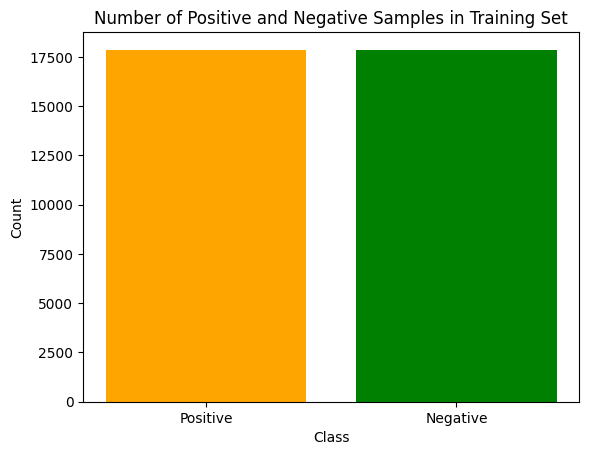

In [58]:
num_positive = sum(y_train_resampled == 1)
num_negative = sum(y_train_resampled == 0)

# Plotting
plt.bar(['Positive', 'Negative'], [num_positive, num_negative], color=['orange', 'green'])
plt.title('Number of Positive and Negative Samples in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [60]:
logRegModel = LogisticRegression(max_iter=10000).fit(X_train_resampled[columns['Columns']],  y_train_resampled.values.ravel())

# Predict the output based on our training and testing dataset
y_train_pred = logRegModel.predict(X_train_resampled[columns['Columns']])
y_test_pred = logRegModel.predict(X_test[columns['Columns']])

In [61]:
evaluate(y_train_resampled, y_train_pred, Y_test, y_test_pred)

**Training Set Metrics**
Accuracy 	: 0.7976883465800962
Precision 	: 0.7935316518571666
Recall 		: 0.8047688346580096
F1 Score 	: 0.7991107405863555

**Test Set Metrics**
Accuracy 	: 0.8129892367906066
Precision 	: 0.5623471882640587
Recall 		: 0.4102259215219976
F1 Score 	: 0.4743898246820213


### Comparing the above three sampling techniques

By analysing the data characteristics, we **decide against using SMOTENC** due to its **sparse one-hot encoded columns** ('type_of_meal_plan_meal plan 1' to 'room_type_reserved_room_type 7'). These sparse categorical features could make it challenging for SMOTENC to generate meaningful synthetic samples. Additionally, there may be highly non-linear relationships between features and the target variable, which may further complicate SMOTENC's effectiveness. <br>
<br>
Comparing the performance of **oversamping** and **undersampling**, undersampling excels in terms of a higher F1 score.  This shows that undersampling can effectively capture relevant information even with a smaller number of samples. Additionally, data resulting from undersampling demands fewer computational resources compared to data obtained through oversampling techniques. Therefore, we decide to apply undersampling on our dataset to solve the imbalance.


In [62]:
# Save undersampled data for future model training
X_train_under_resampled.to_csv('Data/X_train_undersampled_data.csv', index=False)
y_train_under_resampled.to_csv('Data/y_train_undersampled_data.csv', index=False)

## Next Steps

Now, after the pre-processing stage. for the next step, we will train baseline classification models.

## To Navigate To The Next Notebook:
0. [Introduction](/0%20-%20Introduction.ipynb) 
1. [Data Cleaning Notebook](/1%20-%20Data%20Cleaning.ipynb) 
2. [Exploratory Data Analyis Notebook](/2%20-%20Data%20Exploration.ipynb) 
3. [Data Pre-processing Notebook](/3%20-%20Data%20Pre-Processing.ipynb) - <b>[You Are Here Now]</b>
4. [Initial Classification Models Notebook](/4%20-%20ClassificationModels.ipynb)
5. [Feature Engineering Notebook](/5%20-%20Feature%20Engineering.ipynb)
6. Applying Feature Selection + Hyperparameter Tuning On Individual Models
   1. [Logistic Regression Notebook](/6.1%20-%20Logistic%20Regression.ipynb)
   2. [K Nearest Neighbour Notebook](/6.2%20-%20K%20Nearest%20Neighbour.ipynb)
   3. [Decision Tree Notebook](/6.3%20-%20Decision%20Tree.ipynb)
   4. [Support Vector Machine Notebook](/6.4%20-%20SVM.ipynb)
   5. [Random Forest Notebook](/6.5%20-%20Random%20Forest.ipynb)
   6. [Adaboost Notebook](/6.6%20-%20Adaboost.ipynb)
   7. [Gradient Boost Notebook](/6.7%20-%20Gradient%20Boosting.ipynb)
   8. [LightGBM Notebook](/6.8%20-%20LightGBM.ipynb)
7.  [Final Model Comparisons + Conclusion Notebook](/7%20-%20Model%20Comparison,%20Final%20Model%20and%20Conclusion.ipynb)